In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix

from sklearn.compose import make_column_transformer

from sklearn.impute import KNNImputer
from feature_engine import imputation
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser, DecisionTreeDiscretiser
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine import transformation as vt
from feature_engine.creation import CyclicalTransformer, MathematicalCombination, CombineWithReferenceFeature
from feature_engine.selection import RecursiveFeatureElimination, DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures, SelectByShuffling

import lightgbm as lgb

from imblearn.over_sampling import RandomOverSampler
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src.pipe_func import *
from src.eda_functions import *

import warnings
warnings.filterwarnings("ignore")



## Load data and split train and test

In [55]:
# load dataset
song_df = pd.read_csv("../../data/train.csv").set_index('id')
test = pd.read_csv("../../data/test.csv").set_index('id')
song_df.head()


,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
id,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
# convert column to categorical
cat_vars = ['key','audio_mode','time_signature','song_popularity']
song_df[cat_vars] = song_df[cat_vars].astype("object")
test[['key','audio_mode','time_signature']] = test[['key','audio_mode','time_signature']].astype("object")


cont_vars = [var for var in song_df.columns if var not in cat_vars]
cat_vars = ['key','audio_mode','time_signature'] # remove target variable

In [5]:
# split independent and dependent variables
y = song_df['song_popularity'].astype('int')
X = song_df[cont_vars + ['key','audio_mode','time_signature']]


## Missing imputation

In [6]:
add_miss_imputation = imputation.AddMissingIndicator(missing_only=True)
cont_imputation = imputation.MeanMedianImputer(imputation_method='median', variables=cont_vars)
cat_imputation = imputation.CategoricalImputer( variables= cat_vars)

imputation_pipe = Pipeline(steps=[
    ('add_miss_imputation', add_miss_imputation),
    ('cont_imputation', cont_imputation),
    ('cat_imputation', cat_imputation),
])

## feature transformation

In [7]:
lt = vt.LogTransformer(['liveness'])
rt = vt.ReciprocalTransformer(['tempo'])
pt = vt.PowerTransformer(['danceability', 'audio_valence' ])
box_t = vt.BoxCoxTransformer(['speechiness'])
yt = vt.YeoJohnsonTransformer(['song_duration_ms', 'loudness'])

ohe = dummify(variables=cat_vars, drop_first=True)

transformation_pipe = Pipeline(steps=[
    ('LogTransformer', lt),
    ('ReciprocalTransformer', rt),
    ('PowerTransformer', pt),
    ('BoxCoxTransformer', box_t),
    ('YeoJohnsonTransformer', yt),
    ('dummify', ohe),
])

twostep_pipe = Pipeline([
    ('imputation_pipe',imputation_pipe),
    ('transformation_pipe',transformation_pipe)
])

X_2step = twostep_pipe.fit_transform(X)

## feature engineering 1 - kmeans

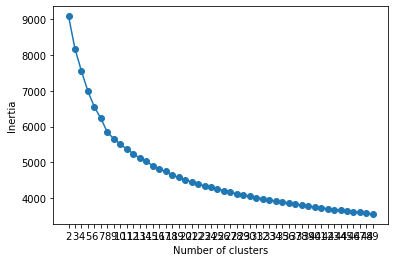

In [ ]:
# 8 clusters show good cut of an elbow point
minmax = MinMaxScaler()
X_3step =  pd.DataFrame(minmax.fit_transform(X_2step), columns=X_2step.columns)

inertia = {}
for i in range(2,50):
    kmeans = KMeans(n_clusters=i, random_state=123)
    kmeans.fit_predict(X_3step[cont_vars])
    inertia.update({i:kmeans.inertia_})

inertia_df = pd.Series(inertia)
plt.plot(inertia_df,marker="o")
plt.xticks(inertia_df.index)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [8]:
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, max_iter=500, n_init=20, random_state=123)
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]

minmax = MinMaxScaler(feature_range=(0.1,1,1))
X_3step =  pd.DataFrame(minmax.fit_transform(X_2step), columns=X_2step.columns)

X_kmeans = kmeans.fit_transform(X_3step[cont_vars])
X_kmeans = pd.DataFrame(X_kmeans, columns=cluster_cols, index = X.index)

X_3step = X_3step.join(X_kmeans)
X_3step

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_11.0,key_Missing,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,0.1,0.1,0.585673,0.546729,0.307282,0.678982,0.516203,0.695409,0.878806,0.686793
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,0.1,0.1,0.168841,0.434010,0.582015,0.952779,0.320646,0.519343,0.887847,0.574816
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,0.1,0.1,0.584305,0.543640,0.673206,0.838440,0.597708,0.227834,0.827965,0.544156
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,0.1,0.1,0.625381,0.443007,0.303804,0.465494,0.560916,0.568940,0.741056,0.405182
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,0.1,0.1,0.550561,0.395131,0.348719,0.695964,0.455949,0.538923,0.832932,0.596539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.640169,0.228542,0.867790,0.543263,0.106094,0.552254,0.399161,0.732567,0.207538,0.407891,...,0.1,0.1,0.594855,0.591743,0.609107,0.757324,0.553406,0.592544,0.811447,0.423591
39996,0.555804,0.167606,0.814923,0.870321,0.104687,0.466720,0.432323,0.890105,0.448406,0.877338,...,0.1,0.1,0.407123,0.382796,0.542777,0.934249,0.175224,0.473668,0.866833,0.557137
39997,0.495703,0.843287,0.603371,0.354381,0.105311,0.440773,0.261981,0.456219,0.527088,0.407639,...,0.1,0.1,1.033658,0.937395,0.646115,0.216183,1.005742,0.982926,0.915104,0.715951
39998,0.561126,0.228542,0.562603,0.710244,0.103948,0.729534,0.571384,0.639042,0.301581,0.867308,...,0.1,0.1,0.300401,0.384872,0.535052,0.835129,0.448903,0.316041,0.816937,0.508088


## Feature engineering 2- interaction

In [9]:
interact_fe = CombineWithReferenceFeature(
    variables_to_combine = cont_vars,
    reference_variables=cont_vars,
    operations=['sub', 'div','add'])

X_4step = interact_fe.fit_transform(X_3step)
X_4step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,song_duration_ms_add_audio_valence,acousticness_add_audio_valence,danceability_add_audio_valence,energy_add_audio_valence,instrumentalness_add_audio_valence,liveness_add_audio_valence,loudness_add_audio_valence,speechiness_add_audio_valence,tempo_add_audio_valence,audio_valence_add_audio_valence
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,1.441559,1.492237,1.783240,1.557624,0.950450,1.336701,1.365367,1.590316,1.081528,1.690233
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,1.378705,0.988533,1.688603,1.654991,0.935953,1.611081,1.370927,1.661341,1.334198,1.662916
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,1.199088,0.867840,1.002003,1.417875,0.740719,1.186812,1.194111,1.268578,0.819828,1.278597
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,1.321253,1.179532,1.410796,1.239655,0.764743,1.063146,1.089715,1.165441,1.010372,1.321141
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,1.355197,1.371614,1.616675,1.590829,0.954378,1.251817,1.572534,1.469604,1.232514,1.698035


## Feature 3: polynomial features


In [10]:
# create 3 degree polynomial features
poly_fe = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_5step_temp = poly_fe.fit_transform(X_4step[cont_vars])
poly_fe_name = poly_fe.get_feature_names(X_4step[cont_vars].columns)
X_5step_temp = pd.DataFrame(X_5step_temp, columns =poly_fe_name)
X_5step = pd.concat([X_4step, X_5step_temp], axis=1, join='inner')
X_5step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,0.596443,0.647120,0.938124,0.712507,0.105334,0.491584,0.520250,0.745200,0.236412,0.845116,...,0.413827,0.131285,0.469313,0.041650,0.148887,0.532238,0.013213,0.047234,0.168850,0.603600
1,0.547247,0.157076,0.857145,0.823533,0.104496,0.779623,0.539469,0.829883,0.502740,0.831458,...,0.571545,0.346240,0.572630,0.209751,0.346897,0.573717,0.127066,0.210149,0.347555,0.574805
2,0.559789,0.228542,0.362704,0.778576,0.101420,0.547513,0.554812,0.629280,0.180529,0.639299,...,0.249190,0.071488,0.253158,0.020509,0.072626,0.257188,0.005884,0.020835,0.073783,0.261283
3,0.660682,0.518961,0.750225,0.579085,0.104172,0.402576,0.429145,0.504870,0.349801,0.660570,...,0.128688,0.089162,0.168375,0.061776,0.116660,0.220302,0.042802,0.080828,0.152637,0.288242
4,0.506179,0.522596,0.767657,0.741811,0.105360,0.402799,0.723517,0.620586,0.383496,0.849018,...,0.239005,0.147695,0.326980,0.091269,0.202060,0.447338,0.056401,0.124865,0.276436,0.611998


## Feature scaling before modeling

In [11]:
mm_scaler = MinMaxScaler()
X_5step_scaled =  pd.DataFrame(mm_scaler.fit_transform(X_5step), columns=X_5step.columns)
X_5step_scaled.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,0.516346,1.328643,1.376518,0.104510,-0.217778,-0.300535,0.307741,0.453796,-1.405563,0.669562,...,0.229905,-0.629958,0.579372,-1.040798,-0.642042,0.774967,-0.945805,-1.064984,-0.598481,0.599056
1,-0.081323,-0.728254,0.843398,0.740795,-0.224824,1.826783,0.463230,0.962532,0.388418,0.590145,...,0.865437,1.083681,1.095451,0.629529,1.214850,0.988533,0.078606,0.499746,0.754491,0.486471
2,0.071046,-0.428285,-2.411751,0.483149,-0.250676,0.112529,0.587358,-0.242602,-1.781984,-0.527168,...,-0.433504,-1.106660,-0.500340,-1.250862,-1.357201,-0.641217,-1.011753,-1.318532,-1.318234,-0.739356
3,1.296771,0.790712,0.139491,-0.660129,-0.227540,-0.957912,-0.429334,-0.989996,-0.641775,-0.403482,...,-0.919069,-0.965763,-0.923834,-0.840809,-0.944268,-0.831138,-0.679575,-0.742328,-0.721232,-0.633950
4,-0.580244,0.805969,0.254252,0.272450,-0.217555,-0.956260,1.952238,-0.294828,-0.414805,0.692246,...,-0.474546,-0.499136,-0.131592,-0.547755,-0.143403,0.337830,-0.557220,-0.319375,0.216048,0.631890


## Feature selection before modelling

In [12]:
# remove duplicates columns
uniq, idxs = np.unique(X_5step_scaled, return_index=True, axis=1)
X_5step_dropduplicates = pd.DataFrame(uniq, index=X_5step_scaled.index, columns=X_5step_scaled.columns[idxs])
X_5step_dropduplicates

,tempo_sub_acousticness,tempo_sub_danceability,cluster3,tempo_sub_song_duration_ms,tempo,tempo_sub_audio_valence,instrumentalness_sub_acousticness,tempo_div_acousticness,tempo_div_danceability,tempo_add_liveness,...,acousticness danceability speechiness,danceability_div_tempo,acousticness loudness audio_valence,acousticness danceability audio_valence,acousticness danceability^2,acousticness danceability energy,key_10.0,acousticness_div_tempo,liveness_na,acousticness danceability loudness
0,-2.073020,-2.009789,-1.697450,-1.427683,-1.405563,-1.372231,-1.319300,-1.313529,-1.310715,-1.280206,...,2.550305,2.630035,2.637282,2.769245,2.840433,2.840677,2.880625,2.963994,2.964713,3.002341
1,0.912423,-0.338907,0.196145,0.365819,0.388418,-0.185744,0.565389,1.016668,-0.197330,1.565923,...,-0.391785,-0.183657,-0.510431,-0.471037,-0.464554,-0.419959,-0.347147,-0.761834,-0.337301,-0.491409
2,-0.641438,0.489686,0.824681,-1.536980,-1.781984,-0.736857,0.278216,-0.964578,-0.492871,-1.279967,...,-0.906252,0.194493,-0.354476,-0.947265,-1.085633,-0.889679,-0.347147,0.703274,-0.337301,-0.874144
3,-1.119615,-0.560303,-1.721421,-1.148303,-0.641775,-0.109685,-0.830035,-1.059813,-0.597611,-1.155034,...,0.340860,0.363076,0.616809,0.702264,0.821365,0.741510,-0.347147,1.037681,-0.337301,0.865432
4,-1.000965,-0.482060,-1.411847,-0.078549,-0.414805,-0.765470,-0.839463,-1.010675,-0.486760,-0.980894,...,0.793391,0.185312,3.173977,1.376151,0.936890,1.472722,2.880625,0.851952,-0.337301,2.634917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-0.534834,-1.810329,0.382879,-1.840349,-1.600055,0.358220,0.296220,-0.867453,-1.353476,-1.116966,...,-0.101995,2.895061,-0.999292,-0.721863,-0.051879,-0.451731,-0.347147,0.450131,-0.337301,-0.397575
39996,0.656401,-0.397178,-0.074299,0.008335,0.022426,-0.610415,0.525557,0.584977,-0.318097,-0.319474,...,-0.306776,-0.043881,-0.611653,-0.407321,-0.494366,-0.338908,-0.347147,-0.667579,-0.337301,-0.686539
39997,-1.699982,0.999132,0.637954,0.797205,0.552426,1.713432,-2.075125,-1.100084,0.758031,-0.048735,...,0.648020,-0.880136,-0.222193,0.300183,0.929898,0.283887,2.880625,1.216391,-0.337301,0.380123
39998,-0.163643,0.110355,-0.127544,-0.856501,-0.966587,-1.190107,0.287955,-0.529269,-0.365351,0.276009,...,-0.647127,0.015963,0.118947,-0.474494,-0.777976,-0.618189,-0.347147,-0.077501,-0.337301,-0.479411


In [13]:
feature_sel_pipe1 = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicates', DropDuplicateFeatures()),
    ('correlated', DropCorrelatedFeatures())
])

X_5step_feature_sel_v1 = feature_sel_pipe1.fit_transform(X_5step_dropduplicates)


## Random oversampling

In [14]:
ros = RandomOverSampler(
        sampling_strategy = 'auto',
        random_state = 123,
        shrinkage = 0.1
    )
X_res, y_res = ros.fit_resample(X_5step_feature_sel_v1, y)

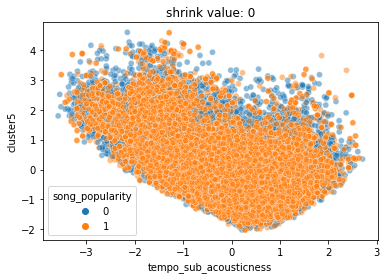

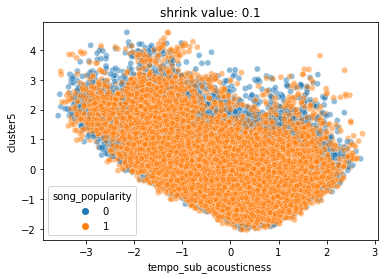

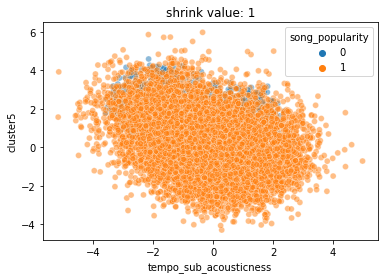

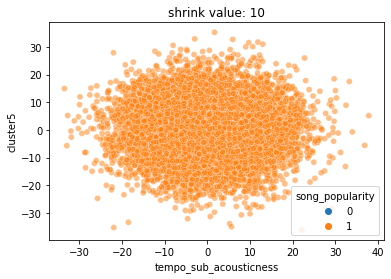

In [26]:
for shrink in [0, 0.1, 1, 10]:
    ros = RandomOverSampler(
        sampling_strategy = 'auto',
        random_state = 123,
        shrinkage = shrink
    )
    X_res, y_res = ros.fit_resample(X_5step_feature_sel_v1, y)
    sns.scatterplot(
        data = X_res, x = 'tempo_sub_acousticness', y = 'cluster5', hue = y_res, alpha = 0.5
    )
    plt.title(f'shrink value: {shrink}')
    plt.show()

In [29]:
train_df = X_res.copy()
train_df['song_popularity'] = y_res

In [45]:
# initial h2o instance
h2o.init()

# change h2o format
train_hf = h2o.H2OFrame(train_df)
train_hf["song_popularity"]= train_hf["song_popularity"].asfactor()


# filter x and y columns
y_var = "song_popularity"
ignore_fields = [y_var]
x_var = [i for i in train_df.columns if i not in ignore_fields]


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,52 mins 18 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_benlc_w6ihds
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.013 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
# cross validation of models
m_10cv = H2OAutoML(max_runtime_secs = 600, seed = 1, nfolds=5, project_name = "h2o_5folds")
m_10cv.train(x_var, y_var, train_hf)

AutoML progress: |██
23:57:12.639: AutoML: XGBoost is not available; skipping it.
23:57:12.641: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:57:12.641: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
00:01:27.424: New models will be added to existing leaderboard h2o_5folds@@song_popularity (leaderboard frame=null) with already 13 models.
00:01:27.425: AutoML: XGBoost is not available; skipping it.
00:01:27.426: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
00:01:27.426: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

█████████████████
00:03:55.308: StackedEnsemble_BestOfFamily_4_AutoML_6_20220201_00127 [StackedEnsemble best_of_family_2 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictio

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,62.0,62.0,15383.0,4.0,4.0,4.0,6.0,16.0,15.145162




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.176683624953206
RMSE: 0.4203375131405785
LogLoss: 0.5065521211858715
Mean Per-Class Error: 0.3498859345500315
AUC: 0.7773423676857119
AUCPR: 0.8289365645478655
Gini: 0.5546847353714237

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3566179731019417: 


,,0,1,Error,Rate
0,0,12565.0,12859.0,0.5058,(12859.0/25424.0)
1,1,4932.0,20492.0,0.194,(4932.0/25424.0)
2,Total,17497.0,33351.0,0.3499,(17791.0/50848.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.356618,0.697303,250.0
1,max f2,0.239523,0.833355,391.0
2,max f0point5,0.515137,0.789921,63.0
3,max accuracy,0.441475,0.720736,122.0
4,max precision,0.994318,1.000000,0.0
5,max recall,0.213070,1.000000,399.0
6,max specificity,0.994318,1.000000,0.0
7,max absolute_mcc,0.520844,0.521900,60.0
8,max min_per_class_accuracy,0.384221,0.690450,202.0
9,max mean_per_class_accuracy,0.441475,0.720736,122.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.992392,2.000000,2.000000,1.000000,0.993036,1.000000,0.993036,0.020020,0.020020,100.000000,100.000000,0.020020
1,2,0.020001,0.991744,2.000000,2.000000,1.000000,0.992037,1.000000,0.992537,0.019981,0.040002,100.000000,100.000000,0.040002
2,3,0.030011,0.991221,2.000000,2.000000,1.000000,0.991470,1.000000,0.992181,0.020020,0.060022,100.000000,100.000000,0.060022
3,4,0.040002,0.990834,2.000000,2.000000,1.000000,0.991022,1.000000,0.991892,0.019981,0.080003,100.000000,100.000000,0.080003
4,5,0.050012,0.990494,2.000000,2.000000,1.000000,0.990655,1.000000,0.991644,0.020020,0.100024,100.000000,100.000000,0.100024
5,6,0.100004,0.988893,2.000000,2.000000,1.000000,0.989691,1.000000,0.990668,0.099984,0.200008,100.000000,100.000000,0.200008
6,7,0.150016,0.987056,2.000000,2.000000,1.000000,0.988009,1.000000,0.989781,0.100024,0.300031,100.000000,100.000000,0.300031
7,8,0.200008,0.983077,2.000000,2.000000,1.000000,0.985493,1.000000,0.988710,0.099984,0.400016,100.000000,100.000000,0.400016
8,9,0.300012,0.434881,1.203540,1.734513,0.601770,0.534429,0.867257,0.837283,0.120359,0.520374,20.353982,73.451327,0.440725
9,10,0.399996,0.404920,0.896538,1.525050,0.448269,0.418567,0.762525,0.732619,0.089640,0.610014,-10.346184,52.505040,0.420036




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.1801537049831205
RMSE: 0.4244451731179429
LogLoss: 0.5140803677690395
Mean Per-Class Error: 0.3835352422907489
AUC: 0.7504685844317011
AUCPR: 0.8101791839180218
Gini: 0.5009371688634021

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3485114393518442: 


,,0,1,Error,Rate
0,0,10668.0,14756.0,0.5804,(14756.0/25424.0)
1,1,4746.0,20678.0,0.1867,(4746.0/25424.0)
2,Total,15414.0,35434.0,0.3835,(19502.0/50848.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.348511,0.679549,265.0
1,max f2,0.219356,0.833333,397.0
2,max f0point5,0.602120,0.788323,43.0
3,max accuracy,0.602120,0.713440,43.0
4,max precision,0.994405,1.000000,0.0
5,max recall,0.207877,1.000000,399.0
6,max specificity,0.994405,1.000000,0.0
7,max absolute_mcc,0.602120,0.520921,43.0
8,max min_per_class_accuracy,0.383585,0.666103,208.0
9,max mean_per_class_accuracy,0.602120,0.713440,43.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.97 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.992357,2.000000,2.000000,1.000000,0.993113,1.000000,0.993113,0.020020,0.020020,100.000000,100.000000,0.020020
1,2,0.020001,0.991648,2.000000,2.000000,1.000000,0.991976,1.000000,0.992545,0.019981,0.040002,100.000000,100.000000,0.040002
2,3,0.030011,0.991132,2.000000,2.000000,1.000000,0.991377,1.000000,0.992155,0.020020,0.060022,100.000000,100.000000,0.060022
3,4,0.040002,0.990671,2.000000,2.000000,1.000000,0.990890,1.000000,0.991839,0.019981,0.080003,100.000000,100.000000,0.080003
4,5,0.050012,0.990253,2.000000,2.000000,1.000000,0.990453,1.000000,0.991562,0.020020,0.100024,100.000000,100.000000,0.100024
5,6,0.100004,0.988459,2.000000,2.000000,1.000000,0.989355,1.000000,0.990459,0.099984,0.200008,100.000000,100.000000,0.200008
6,7,0.150016,0.986429,2.000000,2.000000,1.000000,0.987478,1.000000,0.989465,0.100024,0.300031,100.000000,100.000000,0.300031
7,8,0.200008,0.981641,2.000000,2.000000,1.000000,0.984617,1.000000,0.988253,0.099984,0.400016,100.000000,100.000000,0.400016
8,9,0.300012,0.436654,1.032448,1.677483,0.516224,0.535804,0.838741,0.837437,0.103249,0.503265,3.244838,67.748279,0.406506
9,10,0.399996,0.405207,0.847758,1.470082,0.423879,0.419528,0.735041,0.732975,0.084762,0.588027,-15.224233,47.008211,0.376062




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.621991,0.016720,0.649361,0.619371,0.623205,0.612450,0.605566
1,auc,0.750790,0.005463,0.757238,0.754586,0.751283,0.743760,0.747084
2,err,0.378009,0.016720,0.350639,0.380629,0.376794,0.387550,0.394434
3,err_count,3844.200000,169.893200,3566.000000,3871.000000,3832.000000,3941.000000,4011.000000
4,f0point5,0.623196,0.010791,0.641372,0.617391,0.624532,0.618073,0.614613
5,f1,0.681362,0.003117,0.680351,0.677013,0.685231,0.680917,0.683300
6,f2,0.752002,0.016979,0.724375,0.749381,0.758998,0.757985,0.769272
7,lift_top_group,2.000237,0.024424,2.028725,2.022673,1.993727,1.982648,1.973414
8,logloss,0.514081,0.004243,0.509247,0.510250,0.514526,0.518181,0.518199
9,max_per_class_error,0.565073,0.067298,0.455303,0.563983,0.572500,0.598611,0.634968



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-01 00:05:33,39.143 sec,0.0,0.500000,0.693147,0.500000,0.500000,1.0,0.500000
1,,2022-02-01 00:05:33,39.336 sec,5.0,0.453655,0.601095,0.744878,0.806348,2.0,0.398206
2,,2022-02-01 00:05:34,39.535 sec,10.0,0.435932,0.560311,0.747110,0.808053,2.0,0.380644
3,,2022-02-01 00:05:34,39.740 sec,15.0,0.429080,0.539395,0.749380,0.809578,2.0,0.396023
4,,2022-02-01 00:05:34,39.956 sec,20.0,0.426488,0.528479,0.751554,0.811237,2.0,0.382060
5,,2022-02-01 00:05:34,40.173 sec,25.0,0.425110,0.521853,0.755361,0.813995,2.0,0.379976
6,,2022-02-01 00:05:34,40.388 sec,30.0,0.424167,0.517860,0.758953,0.816779,2.0,0.367527
7,,2022-02-01 00:05:35,40.606 sec,35.0,0.423415,0.514908,0.762367,0.819034,2.0,0.361135
8,,2022-02-01 00:05:35,40.820 sec,40.0,0.422778,0.512506,0.765451,0.821062,2.0,0.373879
9,,2022-02-01 00:05:35,41.036 sec,45.0,0.422154,0.511021,0.768635,0.823261,2.0,0.362099



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,key_11.0,8827.871094,1.000000,0.472062
1,key_4.0,3561.435791,0.403431,0.190445
2,key_1.0,3394.065674,0.384472,0.181495
3,key_3.0,380.517731,0.043104,0.020348
4,key_7.0,318.128296,0.036037,0.017012
5,energy_na,197.485809,0.022371,0.010560
6,key_8.0,166.810913,0.018896,0.008920
7,song_duration_ms_na,103.462326,0.011720,0.005533
8,liveness_sub_acousticness,92.471153,0.010475,0.004945
9,key_5.0,86.341751,0.009781,0.004617



See the whole table with table.as_data_frame()


In [48]:
# Show comparison of all models results
m_10cv.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_6_20220201_00127_model_2,0.750469,0.51408,0.810179,0.383535,0.424445,0.180154
GBM_7_AutoML_6_20220201_00127,0.750353,0.513855,0.810142,0.382139,0.42471,0.180378
GBM_8_AutoML_6_20220201_00127,0.75026,0.514466,0.810116,0.382532,0.425043,0.180661
StackedEnsemble_AllModels_1_AutoML_5_20220131_235712,0.750185,0.512059,0.809892,0.377045,0.42444,0.18015
GBM_10_AutoML_6_20220201_00127,0.749801,0.513995,0.809782,0.422022,0.424744,0.180407
StackedEnsemble_BestOfFamily_2_AutoML_5_20220131_235712,0.749209,0.512535,0.809325,0.384204,0.424671,0.180345
GBM_2_AutoML_5_20220131_235712,0.748502,0.517057,0.809198,0.407863,0.424989,0.180615
GBM_grid_1_AutoML_6_20220201_00127_model_7,0.748481,0.515043,0.808904,0.400527,0.424726,0.180392
GBM_grid_1_AutoML_6_20220201_00127_model_3,0.747857,0.514764,0.808439,0.389278,0.425039,0.180659
StackedEnsemble_BestOfFamily_3_AutoML_5_20220131_235712,0.747828,0.51237,0.808633,0.390025,0.424805,0.180459


## Testing data submission

In [64]:
# imputation and feature transformation
test[cat_vars] = test[cat_vars].astype("object")
X_2step_test = twostep_pipe.fit_transform(test)

# add clusters
n_clusters = 8

X_3step_test =  pd.DataFrame(minmax.transform(X_2step_test), columns=X_2step_test.columns)

X_kmeans_test = kmeans.transform(X_3step_test[cont_vars])
X_kmeans_test = pd.DataFrame(X_kmeans_test, columns=cluster_cols, index = test.index)

X_3step_test = X_3step_test.join(X_kmeans_test)
X_3step_test

# feature interaction
X_4step_test = interact_fe.transform(X_3step_test)

# create 3 degree polynomial features
X_5step_temp_test = poly_fe.transform(X_4step_test[cont_vars])
poly_fe_name_test = poly_fe.get_feature_names(X_4step_test[cont_vars].columns)
X_5step_temp_test = pd.DataFrame(X_5step_temp_test, columns =poly_fe_name_test)
X_5step_test = pd.concat([X_4step_test, X_5step_temp_test], axis=1, join='inner')
X_5step_test.head()

# Scaling
X_5step_scaled_test =  pd.DataFrame(std_scaler.transform(X_5step_test), columns=X_5step_test.columns)

# remove duplicates columns
X_5step_scaled_dropdup_test = X_5step_scaled_test.T.drop_duplicates().T
X_5step_dropduplicates_test = X_5step_scaled_dropdup_test[X_5step_dropduplicates.columns.tolist()]
X_5step_dropduplicates_test

# drop correlated features
X_5step_feature_sel_v1_test = feature_sel_pipe1.transform(X_5step_dropduplicates_test)


In [75]:
test_hf = h2o.H2OFrame(X_5step_feature_sel_v1_test)
submission = m_10cv.leader.predict(test_hf)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [76]:
submission_df = submission.as_data_frame()

In [82]:
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_v2.csv', index=False)

In [91]:
h2o.shutdown()

H2O session _sid_9033 closed.


<ipython-input-91-1edf85295eae>:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


## extend to 30mins training

In [86]:
# initial h2o instance
h2o.init()

# change h2o format
train_hf = h2o.H2OFrame(train_df)
train_hf["song_popularity"]= train_hf["song_popularity"].asfactor()


# filter x and y columns
y_var = "song_popularity"
ignore_fields = [y_var]
x_var = [i for i in train_df.columns if i not in ignore_fields]

# cross validation of models
m_5cv = H2OAutoML(max_runtime_secs = 1800, seed = 1, nfolds=5, project_name = "h2o_5folds")
m_5cv.train(x_var, y_var, train_hf)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\benlc\anaconda3\envs\data-science\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\benlc\AppData\Local\Temp\tmpn97lim36
  JVM stdout: C:\Users\benlc\AppData\Local\Temp\tmpn97lim36\h2o_benlc_started_from_python.out
  JVM stderr: C:\Users\benlc\AppData\Local\Temp\tmpn97lim36\h2o_benlc_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_benlc_ifpqcq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.528 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
01:22:40.722: AutoML: XGBoost is not available; skipping it.
01:22:40.739: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
01:22:40.739: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20220201_12240

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.16622200412109472
RMSE: 0.4077033285626875
LogLoss: 0.48287005804222766
Null degrees of freedom: 9962
Residual degrees of freedom: 9945
Null deviance: 13811.6507198375
Residual deviance: 9621.668776549428
AIC: 9657.668776549428
AUC: 0.8760849514999366
AUCPR: 0.8996829773205804
Gini: 0.7521699029998732

Confusion Matri

,,0,1,Error,Rate
0,0,4278.0,743.0,0.148,(743.0/5021.0)
1,1,1262.0,3680.0,0.2554,(1262.0/4942.0)
2,Total,5540.0,4423.0,0.2012,(2005.0/9963.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.401562,0.785905,161.0
1,max f2,0.341648,0.853076,264.0
2,max f0point5,0.426333,0.846496,122.0
3,max accuracy,0.411473,0.803774,145.0
4,max precision,0.999689,1.000000,0.0
5,max recall,0.243641,1.000000,376.0
6,max specificity,0.999689,1.000000,0.0
7,max absolute_mcc,0.412004,0.619925,144.0
8,max min_per_class_accuracy,0.391700,0.786119,178.0
9,max mean_per_class_accuracy,0.411473,0.802960,145.0



Gains/Lift Table: Avg response rate: 49.60 %, avg score: 50.33 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010037,0.999727,2.015985,2.015985,1.000000,0.999735,1.000000,0.999735,0.020235,0.020235,101.598543,101.598543,0.020235
1,2,0.020074,0.999720,2.015985,2.015985,1.000000,0.999723,1.000000,0.999729,0.020235,0.040469,101.598543,101.598543,0.040469
2,3,0.030011,0.999715,2.015985,2.015985,1.000000,0.999718,1.000000,0.999726,0.020032,0.060502,101.598543,101.598543,0.060502
3,4,0.040048,0.999711,2.015985,2.015985,1.000000,0.999713,1.000000,0.999722,0.020235,0.080737,101.598543,101.598543,0.080737
4,5,0.050085,0.999708,2.015985,2.015985,1.000000,0.999710,1.000000,0.999720,0.020235,0.100971,101.598543,101.598543,0.100971
5,6,0.100070,0.999693,2.015985,2.015985,1.000000,0.999701,1.000000,0.999710,0.100769,0.201740,101.598543,101.598543,0.201740
6,7,0.150055,0.999675,2.015985,2.015985,1.000000,0.999685,1.000000,0.999702,0.100769,0.302509,101.598543,101.598543,0.302509
7,8,0.200040,0.999032,2.015985,2.015985,1.000000,0.999603,1.000000,0.999677,0.100769,0.403278,101.598543,101.598543,0.403278
8,9,0.300010,0.436069,1.716421,1.916164,0.851406,0.502146,0.950485,0.833889,0.171590,0.574868,71.642133,91.616414,0.545392
9,10,0.399980,0.409958,1.299460,1.762027,0.644578,0.422014,0.874028,0.730946,0.129907,0.704775,29.946049,76.202691,0.604795




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.17989225589309205
RMSE: 0.4241370720570085
LogLoss: 0.5110736955009849
Null degrees of freedom: 50847
Residual degrees of freedom: 50828
Null deviance: 70491.03998149563
Residual deviance: 51974.15053766816
AIC: 52014.15053766816
AUC: 0.7523471766232983
AUCPR: 0.8111967309089931
Gini: 0.5046943532465966

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3539333962887343: 


,,0,1,Error,Rate
0,0,11076.0,14348.0,0.5643,(14348.0/25424.0)
1,1,4880.0,20544.0,0.1919,(4880.0/25424.0)
2,Total,15956.0,34892.0,0.3781,(19228.0/50848.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.353933,0.681212,231.0
1,max f2,0.210407,0.833361,397.0
2,max f0point5,0.989337,0.788189,11.0
3,max accuracy,0.504651,0.713794,29.0
4,max precision,0.999637,1.000000,0.0
5,max recall,0.210407,1.000000,397.0
6,max specificity,0.999637,1.000000,0.0
7,max absolute_mcc,0.989337,0.520769,11.0
8,max min_per_class_accuracy,0.381926,0.666654,174.0
9,max mean_per_class_accuracy,0.504651,0.713794,29.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.00 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010010,0.999696,2.000000,2.000000,1.000000,0.999709,1.000000,0.999709,0.020020,0.020020,100.000000,100.000000,0.020020
1,2,0.020001,0.999683,2.000000,2.000000,1.000000,0.999689,1.000000,0.999699,0.019981,0.040002,100.000000,100.000000,0.040002
2,3,0.030011,0.999674,2.000000,2.000000,1.000000,0.999678,1.000000,0.999692,0.020020,0.060022,100.000000,100.000000,0.060022
3,4,0.040041,0.999665,2.000000,2.000000,1.000000,0.999669,1.000000,0.999686,0.020060,0.080082,100.000000,100.000000,0.080082
4,5,0.050012,0.999657,2.000000,2.000000,1.000000,0.999661,1.000000,0.999681,0.019942,0.100024,100.000000,100.000000,0.100024
5,6,0.100004,0.999604,2.000000,2.000000,1.000000,0.999634,1.000000,0.999658,0.099984,0.200008,100.000000,100.000000,0.200008
6,7,0.150016,0.999391,2.000000,2.000000,1.000000,0.999500,1.000000,0.999605,0.100024,0.300031,100.000000,100.000000,0.300031
7,8,0.200008,0.998661,2.000000,2.000000,1.000000,0.999155,1.000000,0.999493,0.099984,0.400016,100.000000,100.000000,0.400016
8,9,0.300012,0.419813,1.041888,1.680629,0.520944,0.517618,0.840315,0.838868,0.104193,0.504209,4.188791,68.062930,0.408394
9,10,0.399996,0.397726,0.835169,1.469295,0.417585,0.407588,0.734648,0.731064,0.083504,0.587712,-16.483084,46.929544,0.375433


In [90]:
# Show comparison of all models results
m_5cv.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_3_AutoML_1_20220201_12240,0.752347,0.511074,0.811197,0.378147,0.424137,0.179892
StackedEnsemble_AllModels_6_AutoML_1_20220201_12240,0.752217,0.51099,0.811224,0.396771,0.424114,0.179873
StackedEnsemble_AllModels_4_AutoML_1_20220201_12240,0.751903,0.511147,0.81097,0.389357,0.424181,0.17993
StackedEnsemble_BestOfFamily_7_AutoML_1_20220201_12240,0.751824,0.511068,0.811016,0.388295,0.42419,0.179937
StackedEnsemble_AllModels_2_AutoML_1_20220201_12240,0.751686,0.511292,0.810558,0.399544,0.424235,0.179975
GBM_grid_1_AutoML_1_20220201_12240_model_14,0.751558,0.51332,0.810882,0.386741,0.42428,0.180014
StackedEnsemble_BestOfFamily_5_AutoML_1_20220201_12240,0.751314,0.511471,0.810721,0.381234,0.424387,0.180104
StackedEnsemble_BestOfFamily_4_AutoML_1_20220201_12240,0.751188,0.511498,0.810604,0.414687,0.424399,0.180114
StackedEnsemble_AllModels_1_AutoML_1_20220201_12240,0.751133,0.511758,0.810249,0.396594,0.424308,0.180037
StackedEnsemble_BestOfFamily_3_AutoML_1_20220201_12240,0.751032,0.511515,0.810228,0.403969,0.424365,0.180086


In [92]:
test_hf = h2o.H2OFrame(X_5step_feature_sel_v1_test)
submission = m_10cv.leader.predict(test_hf)

H2OConnectionError: Connection was closed, and can no longer be used.

In [ ]:
submission_df = submission.as_data_frame()

In [ ]:
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_v2.csv', index=False)